# NBA Player Salary Prediction using Deep Neural networks

Welcome! In this notebook, I will be building an L-Layer Deep Neural network to predict NBA Player salaries based on their season averages

In [372]:
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

In [373]:
salaries = pd.read_csv('./Nba Player Salaries.csv')

In [374]:
salaries

,Player Id,Player Name,2022/2023,2023/2024,2024/2025,2024/2025.1
0,1,Stephen Curry,"$48,070,014","$51,915,615","$55,761,217","$59,606,817"
1,2,John Wall,"$47,345,760",$0,$0,$0
2,3,Russell Westbrook,"$47,080,179",$0,$0,$0
3,4,LeBron James,"$44,474,988","$46,698,737","$50,434,636",$0
4,5,Kevin Durant,"$44,119,845","$47,649,433","$51,179,020","$54,708,608"
...,...,...,...,...,...,...
569,570,Gabe York,"$32,171",$0,$0,$0
570,571,Ibou Badji,"$18,226","$1,761,752",$0,$0
571,572,Tristan Thompson,"$16,700",$0,$0,$0
572,573,RaiQuan Gray,"$5,849","$547,349",$0,$0


We're only gonna analyze salaries for 2024/25 so let's drop the other salary columns

In [375]:
salaries_cropped = salaries.drop(['Player Id', '2022/2023', '2023/2024', '2024/2025.1'], axis = 1)

In [376]:
df = salaries_cropped

# Select only the salary columns (exclude 'Player Name')
salary_columns = df.columns.drop('Player Name')

# Remove '$' and ',' from salary columns and convert to float for comparison
df[salary_columns] = df[salary_columns].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Filter out rows where any of the salary columns have a value of 0
df_cleaned = df[(df[salary_columns] != 0).all(axis=1)]

# If you want to revert the formatting back to '$' and ',' for display
df_cleaned[salary_columns] = df_cleaned[salary_columns]

df_cleaned

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Player Name,2024/2025
0,Stephen Curry,55761217.0
3,LeBron James,50434636.0
4,Kevin Durant,51179020.0
5,Bradley Beal,50203930.0
6,Paul George,48787676.0
...,...,...
480,Carlik Jones,2092344.0
481,Juwan Morgan,576230.0
482,Malik Fitts,555217.0
526,Didi Louzada,268032.0


In [377]:
salaries_final = df_cleaned

In [378]:
salaries_final['Player Name'] = salaries_final['Player Name'].str.lower()
salaries_final['2024/2025'] = salaries_final['2024/2025'] / (1000000)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [380]:
stats = pd.read_csv('season_stats.csv')

In [381]:
stats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,1,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,2.6,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6,achiupr01
1,2,Bam Adebayo,C,26,MIA,71,71,34.0,7.5,14.3,...,2.2,8.1,10.4,3.9,1.1,0.9,2.3,2.2,19.3,adebaba01
2,3,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,0.9,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8,agbajoc01
3,4,Santi Aldama,PF,23,MEM,61,35,26.5,4.0,9.3,...,1.2,4.6,5.8,2.3,0.7,0.9,1.1,1.5,10.7,aldamsa01
4,5,Nickeil Alexander-Walker,SG,25,MIN,82,20,23.4,2.9,6.6,...,0.4,1.6,2.0,2.5,0.8,0.5,0.9,1.7,8.0,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,568,Thaddeus Young,PF,35,TOT,33,6,13.3,2.0,3.3,...,1.4,1.7,3.1,1.7,0.7,0.2,0.5,1.5,4.2,youngth01
568,569,Trae Young,PG,25,ATL,54,54,36.0,8.0,18.7,...,0.4,2.3,2.8,10.8,1.3,0.2,4.4,2.0,25.7,youngtr01
569,570,Omer Yurtseven,C,25,UTA,48,12,11.4,2.1,3.8,...,1.5,2.8,4.3,0.6,0.2,0.4,0.8,1.1,4.6,yurtsom01
570,571,Cody Zeller,C,31,NOP,43,0,7.4,0.6,1.4,...,1.1,1.5,2.6,0.9,0.2,0.1,0.4,1.0,1.8,zelleco01


In [382]:
stats['Player'] = stats['Player'].str.lower()

In [383]:
salaries_final = salaries_final.rename(columns={'Player Name': 'Player'})

In [384]:
merged_data = pd.merge(stats, salaries_final, on='Player', how='inner')

In [385]:
merged_data

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional,2024/2025
0,1,precious achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6,achiupr01,6.275861
1,2,bam adebayo,C,26,MIA,71,71,34.0,7.5,14.3,...,8.1,10.4,3.9,1.1,0.9,2.3,2.2,19.3,adebaba01,34.848340
2,3,ochai agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8,agbajoc01,4.310280
3,7,jarrett allen,C,25,CLE,77,77,31.7,6.7,10.6,...,7.4,10.5,2.7,0.7,1.1,1.6,1.9,16.5,allenja01,20.000000
4,9,jose alvarado,PG,25,NOP,56,0,18.4,2.5,6.2,...,1.8,2.3,2.1,1.1,0.3,0.7,1.6,7.1,alvarjo01,1.988598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,559,ziaire williams,SF,22,MEM,51,15,20.4,2.9,7.4,...,2.8,3.5,1.5,0.7,0.2,1.3,1.7,8.2,willizi02,6.133005
185,560,zion williamson,PF,23,NOP,70,70,31.5,8.9,15.6,...,4.1,5.8,5.0,1.1,0.7,2.8,2.3,22.9,willizi01,36.180000
186,564,james wiseman,C,22,DET,63,6,17.3,3.0,4.8,...,3.6,5.3,0.9,0.2,0.6,1.0,2.2,7.1,wisemja01,15.815870
187,569,trae young,PG,25,ATL,54,54,36.0,8.0,18.7,...,2.3,2.8,10.8,1.3,0.2,4.4,2.0,25.7,youngtr01,43.031940


In [386]:
merged_data = merged_data.fillna(0.0)

As you can see, this model is not very good at predicting the salaries at all. Let's try increasing the number of layers and number of nodes per layer and see if that helps

Wow, this model got a lot better at predicting the salaries

Great! We've brought the error down by a significant margin. now let's see if normalizing the data before training the model can help

Given how limited our training dataset was (~ 180 training samples), this is not bad! We can try to improve on this by gathering more data. That's an exercise for another day

As you can see, the predicted values are closest to the actual salaries for some of the highest paid players

In [388]:
feature_cols = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# feature_cols = ['FG%', '3P%', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

features = merged_data[feature_cols]
target = merged_data['2024/2025']

In [389]:
features = StandardScaler().fit_transform(features)
target = merged_data['2024/2025']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [390]:
# define regression model
def regression_model(x_train, y_train, num_hidden_layers, num_nodes_per_layer, n_epochs):
    # create model
    model = Sequential()
    # 2 hidden layers with 3 nodes each
    model.add(Dense(num_nodes_per_layer, activation='relu', input_shape=(x_train.shape[1],)))
    for i in range(num_hidden_layers):
        model.add(Dense(num_nodes_per_layer, activation='relu'))
    model.add(Dense(1, activation='relu'))

    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs = n_epochs, verbose=0)
    
    return model

In [391]:
model = regression_model(x_train, y_train, 5, 10, 100)
print('Square root of the MSE = ', np.sqrt(mean_squared_error(y_test, model.predict(x_test))))

Square root of the MSE =  11.290175933654663


In [392]:
x = StandardScaler().fit_transform(merged_data[feature_cols])

merged_data['predicted_salary'] = model.predict(x)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [393]:
merged_data['diff'] = np.absolute(merged_data['2024/2025'] - merged_data['predicted_salary'])

In [394]:
highest_diff = merged_data.sort_values(by='diff', ascending = False).head(30)

So these are the  30 players with the biggest difference in predicted salary versus actual salary 

Let's analyze the most overpaid and the most underpaid among them

In [395]:
overpaid = highest_diff[highest_diff['2024/2025'] > highest_diff['predicted_salary']]
overpaid = overpaid.sort_values(by='2024/2025', ascending = False)

In [396]:
underpaid = highest_diff[highest_diff['2024/2025'] < highest_diff['predicted_salary']]
underpaid = underpaid.sort_values(by='2024/2025', ascending = False)

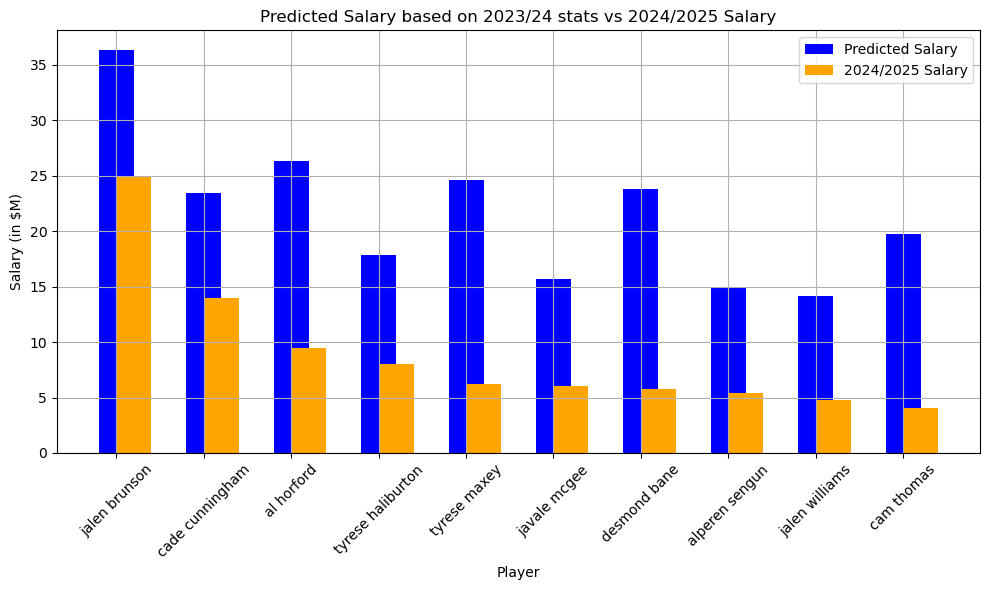

In [397]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plot the actual and predicted salaries
plt.bar(underpaid['Player'], underpaid['predicted_salary'], color='blue', width=0.4, label='Predicted Salary', align='center')
plt.bar(underpaid['Player'], underpaid['2024/2025'], color='orange', width=0.4, label='2024/2025 Salary', align='edge')

# Add labels and title
plt.xlabel('Player')
plt.ylabel('Salary (in $M)')
plt.title('Predicted Salary based on 2023/24 stats vs 2024/2025 Salary')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Let's analyze this data for a bit

1. According to our model, Jalen Brunson is getting paid a LOT less than what he should be getting paid. This hypothesis is validated by the fact that he was one of the most impactful players in the playoffs this past season and was eligible for a max extension this offseason (but chose to take a team friendly deal)

2. Some other players like Cade Cunningham, Tyrese Haliburton, Jalen Williams, Tyrese Maxey and Alperen Sengun are also on this list, getting paid a lot less than their predicted values. What's one thing in common between them? They are all on rookie contracts! With their second contracts, these players will get paid a lot more money, in alignment with the value they bring to their teams

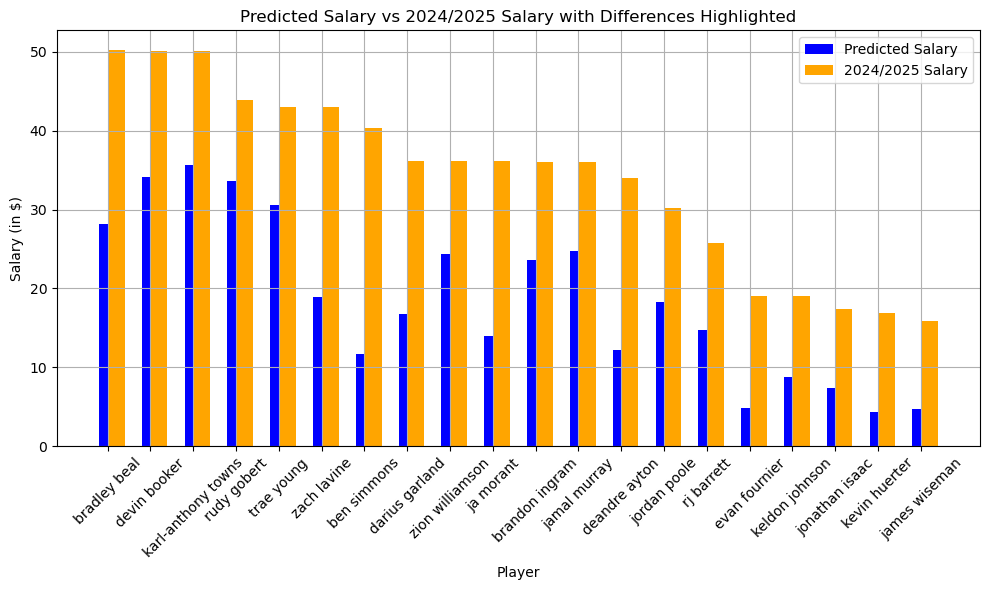

In [399]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plot the actual and predicted salaries
plt.bar(overpaid['Player'], overpaid['predicted_salary'], color='blue', width=0.4, label='Predicted Salary', align='center')
plt.bar(overpaid['Player'], overpaid['2024/2025'], color='orange', width=0.4, label='2024/2025 Salary', align='edge')

# Add labels and title
plt.xlabel('Player')
plt.ylabel('Salary (in $)')
plt.title('Predicted Salary vs 2024/2025 Salary with Differences Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Let's take a closer look at this data

1. Bradley Beal's salary disparity makes sense because he plays for the Suns but is currently on a super max contract from Washington, suffered nagging injuries and didn't play much this season and performed well below his expectations

2. Ben Simmons also has a huge salary disparity and is on one of the worst contracts in the league and struggles to stay healthy while Zion Williamson is on a super max extension but also has had some injuries recently

3. Devin Booker is a bit of a surprising addition to this list, considering he did not seem to have a "down" year, but it could be explained by the fact that he is now playing with 2 superstars in Kevin Durant and Bradley Beal, and his sttas are bound to take a hit.

4. Jordan Poole had a very disappointing year on the Wizards after getting paid by the Warriors just one season ago